# $\mu$-learn

$\mu$-learn (read mooh-learn) is a python package implementing the metodology for data-driven induction of fuzzy sets described in

- D. Malchiodi and W. Pedrycz, Learning Membership Functions for Fuzzy Sets through Modified Support Vector Clustering, in F. Masulli, G. Pasi e R. Yager (Eds.), Fuzzy Logic and Applications. 10th International Workshop, WILF 2013, Genoa, Italy, November 19–22, 2013. Proceedings., Vol. 8256, Springer International Publishing, Switzerland, Lecture Notes on Artificial Intelligence, 2013;
- D. Malchiodi and A. G. B. Tettamanzi, Predicting the Possibilistic Score of OWL Axioms through Modified Support Vector Clustering, in H. Haddad, R. L. Wainwright e R. Chbeir (Eds.), SAC'18: Proceedings of the 33rd Annual ACM Symposium on Applied Computing, ACM (ISBN 9781450351911), 1984–1991, 2018.


## Install

The package can easily be installed:

- via `pip`, by running `pip install mulearn` in a terminal;
- through `conda`, by running `conda install -c dariomalchiodi mulearn`;
- cloning the source repo at https://github.com/dariomalchiodi/mulearn.

APIs are described at https://mulearn.readthedocs.io/.


## How to use
Consider the Iris dataset, whose 150 observations describe each a flower of the Iris species in terms of its sepal and petal width and length, as well as of its class (Setosa, Versicolor, and Virginica), as exemplified here below. We will use the class as _labels_ to be predicted, and the remaining four attributes as the description of each object in the dataset. Referring to the values of the description of an object as a _pattern_, our aim will be that of predicting the class on the basis of the description.

In [1]:
import sklearn.datasets as ds
import pandas as pd
import numpy as np

iris_X, iris_y = ds.load_iris(return_X_y=True)
labels = ("Setosa", "Versicolor", "Virginica")

df = pd.DataFrame(iris_X, columns=["Sepal length", "Sepal width",
                                   "Petal length", "Petal width"])
df['Class'] = iris_y
df['Class'] = df['Class'].map(lambda c: labels[c])
df.head()

,Sepal length,Sepal width,Petal length,Petal width,Class
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


For sake of visualization, let's extract the first two principal components in the descriptions, so that the patterns we will focus on will be bidimensional vectors, save them in `iris_X_2d`, and generate the corresponding scatter plot, coloring bullets in function of the label of the corresponding pattern. We implement a `gr_dataset` method which computes and shows this plot, in order to regenerate it easily in the subsequent cells.

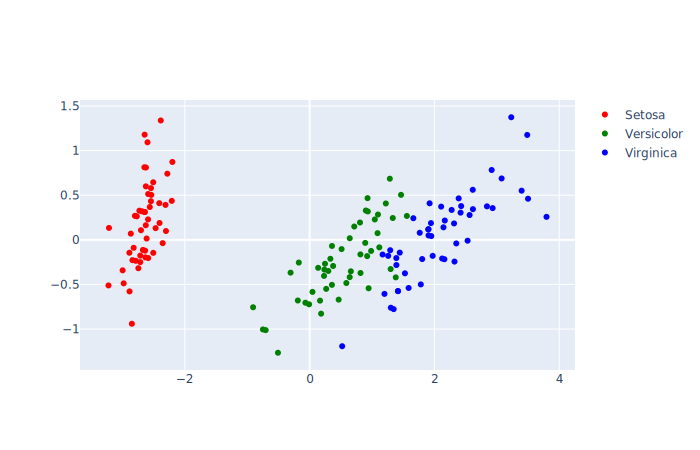

In [2]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
iris_X_2d = pca_2d.fit_transform(iris_X)

import plotly.graph_objects as go

def gr_dataset(fig): 
    for lab, col in enumerate(("red", "green", "blue")):
        fig.add_trace(go.Scatter(x=iris_X_2d[iris_y==lab, 0],
                                 y=iris_X_2d[iris_y==lab, 1],
                                 mode="markers",
                                 marker_color=col,
                                 name=labels[lab]))

fig = go.Figure()
gr_dataset(fig)
f = go.FigureWidget(fig)
f.show("svg")

Let's focus on one of the three classes in the dataset, namely Versicolor, and use the mulearn package in order to infer the corresponding fuzzy set. The available class labels refer to a three-classes setting, where 0, 1, and 2 correspond to Setosa, Versicolor, and Virginica, respectively. Therefore, converting each 2 in these labels to 0 has the effect of generating new labels which we will store in `iris_versicolor`, now describing the crisp membership to the Versicolor set. We will exploit these labels in order to learn the membership function to the corresponding fuzzy set $V$. 

In [4]:
iris_versicolor = iris_y.copy()
iris_versicolor[iris_versicolor==2] = 0

The inference of the membership function $\mu_V$ is done using the main class of the package, called `FuzzyInductor`, starting from the patterns in `iris_X_2d` and the corresponding labels in `iris_versicolor`. This class exposes an interface analogous to that of estimators in Scikit-Learn, thus learning happens through invokation of the `fit` method on an insance of the class, specifying patterns and labels as arguments.

In [5]:
from mulearn import FuzzyInductor

fi = FuzzyInductor()
fi.fit(iris_X_2d, iris_versicolor)

FuzzyInductor(c=1, k=GaussianKernel(), f=ExponentialFuzzifier(), solver=GurobiSolver())

After `fit` has been invoked successfully, the `predict` method of the class is available for computing predictions for the membersip function $\mu_V$. For instance, in the origin of the considered space we have

In [5]:
fi.predict([(0, 0)])

array([0.76792676])

which means that $\mu_V((0, 0))$ is predicted as around 0.7679. Note that even if we wanted to predict the label for a sole pattern, `predict` has been called specifying as input a list containing such pattern, and it has returned an array contaning its membership value. In general, the argument to `predict` can be a list, a tuple, or a numpy array, containing in all cases patterns (described themselves as lists, tuples, or arrays) having a same length. Its return value will be an array of that same length, gathering the inferred membership values.

The following cell defines a function `gr_membership_contour`, taking as input the membership function and producing its contour plot, superposed with the scatter plot of the dataset.

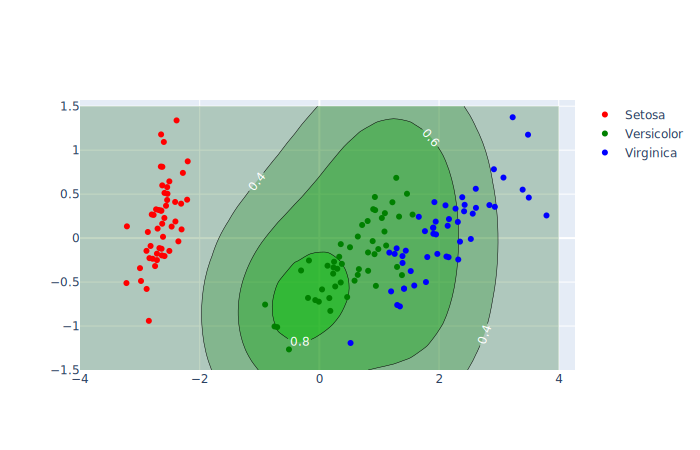

In [6]:
def gr_membership_contour(estimated_membership):
    fig = go.Figure()
    gr_dataset(fig)
    x = np.linspace(-4, 4, 30)
    y = np.linspace(-1.5, 1.5, 30)
    X, Y = np.meshgrid(x, y)
    zs = estimated_membership(np.array((np.ravel(X), np.ravel(Y))).T)
    Z = zs.reshape(X.shape)

    fig.add_trace(go.Contour(x=x, y=y, z=Z,
                             colorscale=[[0, 'rgba(0, 0.1, 0, 0.0)'],
                                         [1, 'rgba(0, 0.9, 0, 0.5)']],
                             line_smoothing=0.85,
                             contours={"start": 0, "end": 1, "size": .2,
                                       "showlabels": True,
                                       "labelfont": {"size": 12,
                                                     "color": "white"}
                                       },
                             showscale=False))
    go.FigureWidget(fig).show("svg")

gr_membership_contour(fi.predict)

The `predict` method can also be used in order to obtain a binary classification, that is computing membership to the crisp set corresponding to $V$. This is done performing an $\alpha$-cut on the membership function, and the value of $\alpha$ should be specified through the `alpha` parameter.

In [7]:
fi.predict([(0, 0), (3, 0)], alpha=0.5)

array([1, 0])

Hyper-parameters of the learning algorithm, that according to the interface required by Scikit-learn should be specified during object creation, are described here below.

### C
The argument `c` allows to wheigth the trade-off between the errors in the approximation of the provided dataset and the generalization ability.

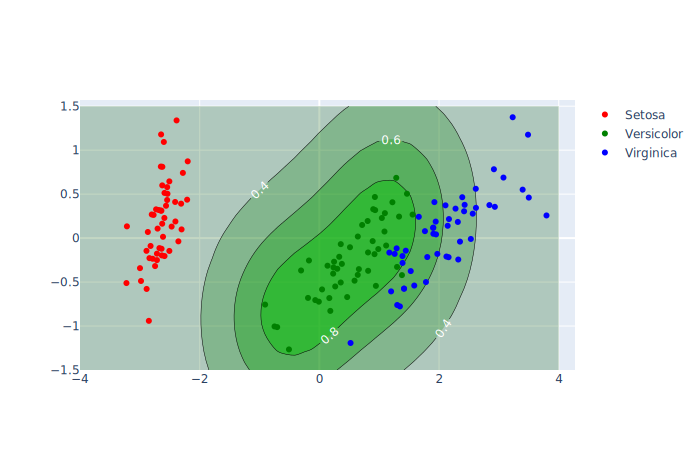

In [8]:
fi = FuzzyInductor(c=.1)
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

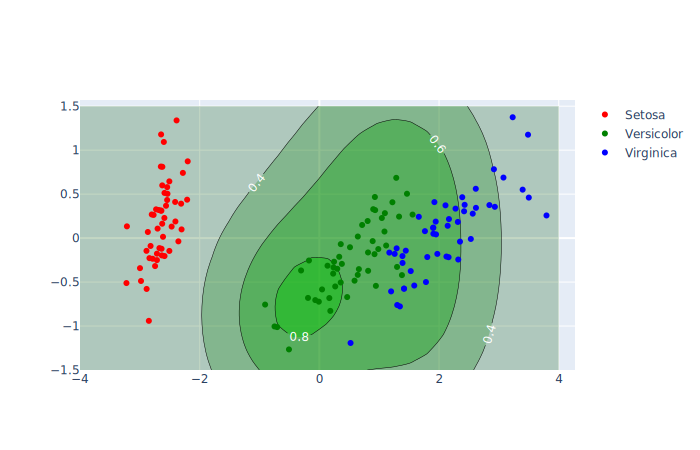

In [9]:
fi = FuzzyInductor(c=100)
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

### Fuzzifier

This hyper-parameter, regulating how the learnt membership function decreases from 1 to 0, is specified through the `fuzzifier` argument. The corresponding value should be set to an object of one of the classes in the `mulearn.fuzzifier` module. Without being too specific on the inner working of the learning algorithm, the latter finds a mapping $\Phi$ of the patterns onto a so-called _feature space_ implicitly defined by the chosen kernel (described in the next section). The images of patterns via this mapping have a distance w.r.t. a special point (called _center_) which can be related to to their membership value. In particular, the learning algorithm builds a function $R^2$ associating any possible pattern to the squared distance of its image through $\Phi$ and the above mentioned center, as well as the value for this distance, called _radius_, which corresponds to a predicted membership of 0.5.

The simplest fuzzifier only assumes `0` and `1` as values, thus it corresponds to a crisp set. Basically, it is found by thresholding the values of $R$ using the inferred radius. It is specified via the `mulearn.fuzzifier.CrispFuzzifier` class.

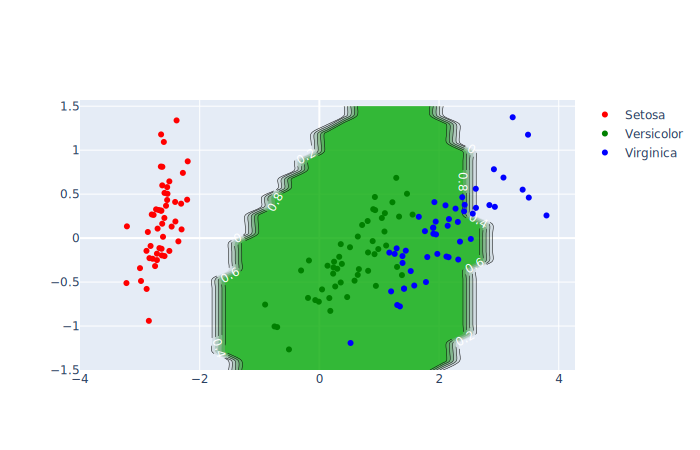

In [10]:
from mulearn.fuzzifier import CrispFuzzifier

fi = FuzzyInductor(fuzzifier=CrispFuzzifier())
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.decision_function)

Note that the obtained figure can be misleading, because we should obtain only one contour dividing positive and negative predictions. To avoid this behaviour, due to the fact that the plotted function increases instantaneously from 0 to 1, we can slightly modify the `gr_membership_contour` function, adding a parameter to deal with this special configuration.

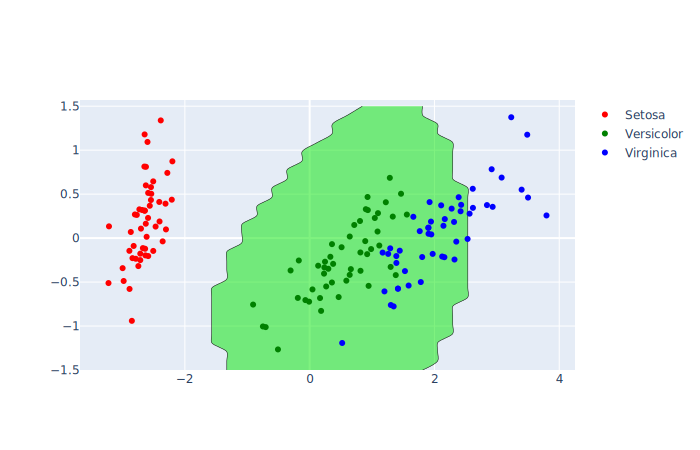

In [11]:
def gr_membership_contour(estimated_membership, crisp=False):
    fig = go.Figure()
    gr_dataset(fig)
    x = np.linspace(-3.5, 3.5, 30)
    y = np.linspace(-1.5, 1.5, 30)
    X, Y = np.meshgrid(x, y)
    zs = estimated_membership(np.array((np.ravel(X), np.ravel(Y))).T)
    Z = zs.reshape(X.shape)
    
    contour_desc = {"start": 0., "end": 1., "size": .2,
                    "showlabels": True,
                    "labelfont": {"size": 12, "color": "white"}}
    if crisp:
        contour_desc["start"] = .999
        contour_desc["end"] = 1.1
        del contour_desc["showlabels"]
        del contour_desc["labelfont"]

    fig.add_trace(go.Contour(x=x, y=y, z=Z,
                             colorscale=[[0, 'rgba(0, 0.1, 0, 0.0)'],
                                         [1, 'rgba(0, 0.9, 0, 0.5)']],
                             line_smoothing=0.85,
                             contours=contour_desc,
                             showscale=False))
    go.FigureWidget(fig).show("svg")
    
gr_membership_contour(fi.predict, crisp=True)

The induction of a fuzzy set is typically done in order to deal with membership degrees not necessarily equal to `0` and `1`. One of the simplest non-Boolean fuzzifier linearly decreases from 1 to 0. It is specified via the `mulearn.fuzzifier.LinearFuzzifier` class, which in its simplest form does not require specific options.

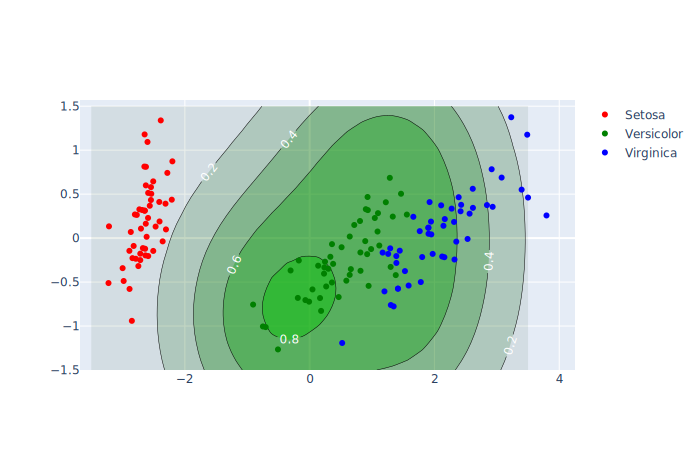

In [12]:
from mulearn.fuzzifier import LinearFuzzifier

fi = FuzzyInductor(fuzzifier=LinearFuzzifier())
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

Note that the above mentioned linear decrease is not usually done in feature space, rather than in the space of patterns. This is why the shown contours have an asymmetrical shape.

When the no arguments are provided to the fuzzifier constructor, the former is typically built using the inferred $R^2$ and radius. Alternatively, it is possible to tune it according to the data provided to the learning algorithm, by specifying the `profile='infer'` argument to the constructor.

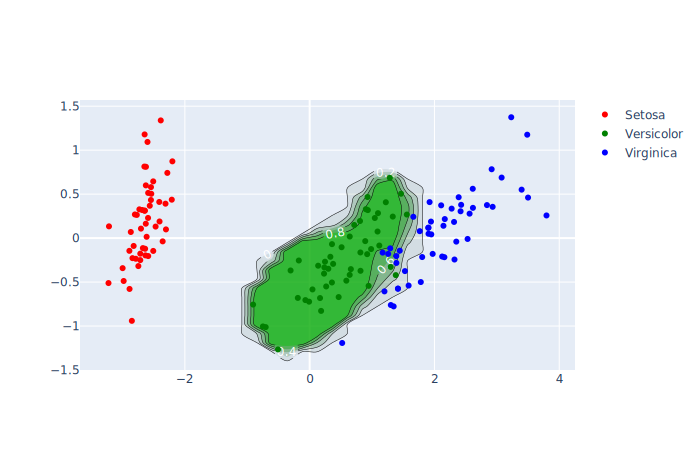

In [13]:
fi = FuzzyInductor(fuzzifier=LinearFuzzifier(profile='infer'))
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

The `ExponentialFuzzifier` class implements a fuzzifier characterized by an exponential decay of the membership in feature space. The rate of this decay can be set in terms of the radius or fitting the data, precisely using the same syntax of `LinearFuzzifier`. Moreover, the decay can be manually set jointly specifying the `profile` and `alpha` arguments.

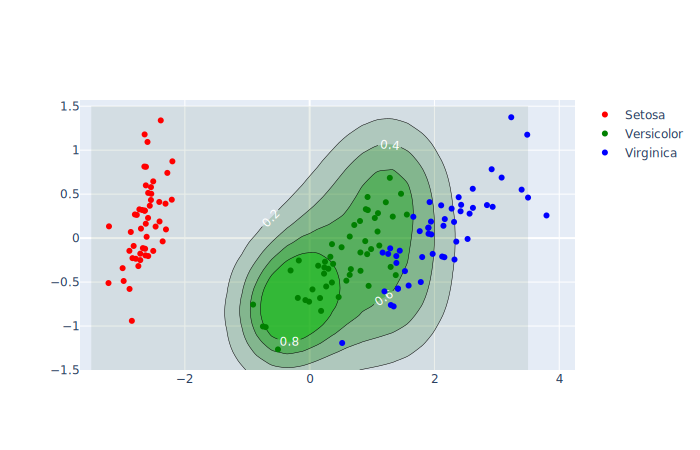

In [14]:
from mulearn.fuzzifier import ExponentialFuzzifier

fi = FuzzyInductor(fuzzifier=ExponentialFuzzifier(profile='alpha', alpha=0.1))
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

Finally, `QuantileConstantPiecewiseFuzzifier` and `QuantileLinearPiecewiseFuzzifier` implement two fuzzifiers whose decay is automatically inferred using as reference points the quantiles of the squared distances of (images of) points w.r.t. the inferred center in feature space. There reference points are used, respectively, to build a piecewise constant and a piecewise membership function in feature space.

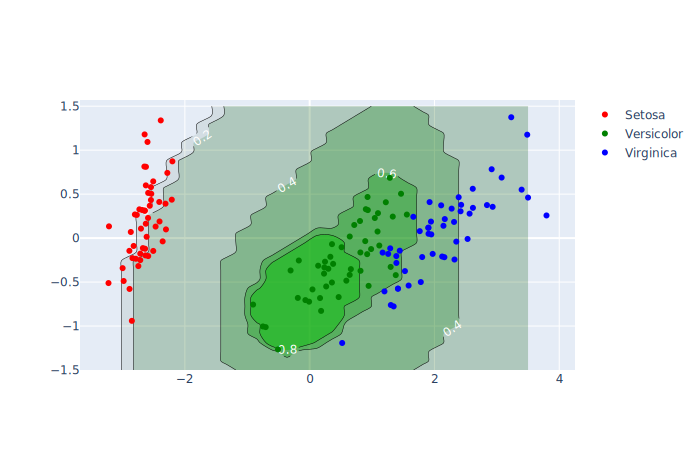

In [15]:
from mulearn.fuzzifier import QuantileConstantPiecewiseFuzzifier

qp = QuantileConstantPiecewiseFuzzifier()
fi = FuzzyInductor(fuzzifier=qp)
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

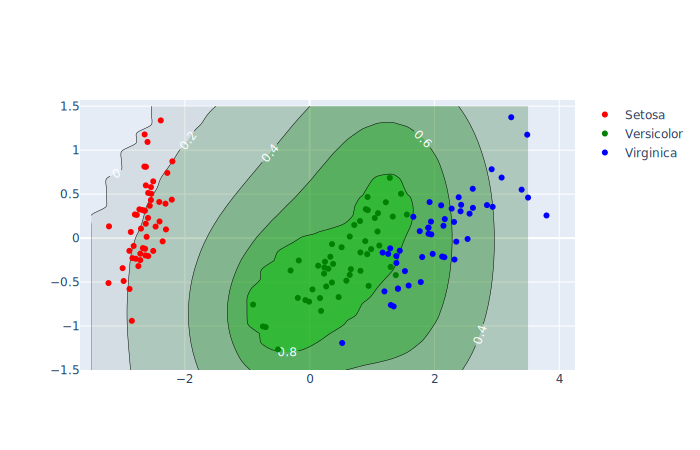

In [16]:
from mulearn.fuzzifier import QuantileLinearPiecewiseFuzzifier

fi = FuzzyInductor(fuzzifier=QuantileLinearPiecewiseFuzzifier())
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

Once used in order to fit a `FuzzyInductor` object, a fuzzifier can be queried for its so-called _profile_, which is a mapping from the squared distance in feature space to the membership value. This is done thrpugh invocation of its `get_profile` method, specifying as arguments the patterns used in order to learn the membership function. The method returns a triple containing, respectively, the squared distances of all images of the provided patterns w.r.t. the learnt center, an array of synthesized values for such distance, and the corresponding array of memberships. The following cell uses this information in order to plot the inferred profile $\hat\mu$, together with the actual memberships of the provided patterns (labeled with $\mu$ in the picture).

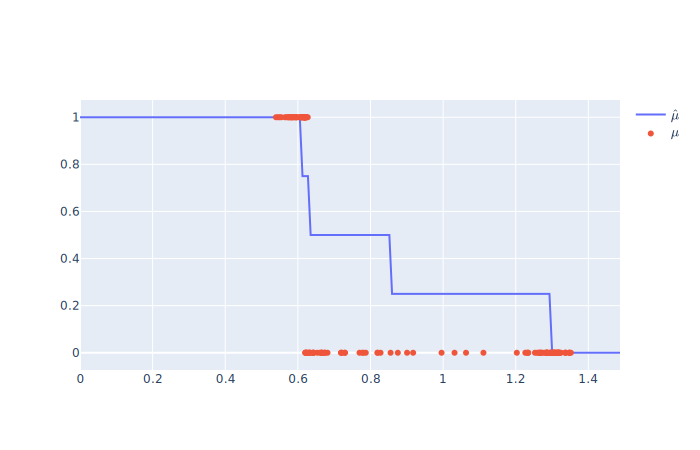

In [17]:
r, r_synth, mu_synth = qp.get_profile(iris_X_2d)

fig = go.Figure(data=go.Scatter(x=r_synth, y=mu_synth, name=r'$\hat\mu$'))
fig.add_trace(go.Scatter(x=r, y=iris_versicolor, mode='markers', name=r'$\mu$'))
fig.show("svg")

Note that we had to save the used fuzzifier in a variable, rather than creating the corresponding object on the fly when instantiating `FuzzyInductor`. This allowed us to subsequently invoke `get_profile`.

### Kernel

The so-called _kernel_ function describes how to compute the inner product of two images of patterns in feature space. Kernels are implemented in the `mulearn.kernel` package: when not explicitly passed to `FuzzyInductor`, a _Gaussian kernel_ with predefined parameter value is used. It is however possible to change this value by explicitly instantiating the `GaussianKernel` class. The closest to zero is the value for the parameter, the bigger flexibility will be used in order to fit the membership function to the provided dataset.

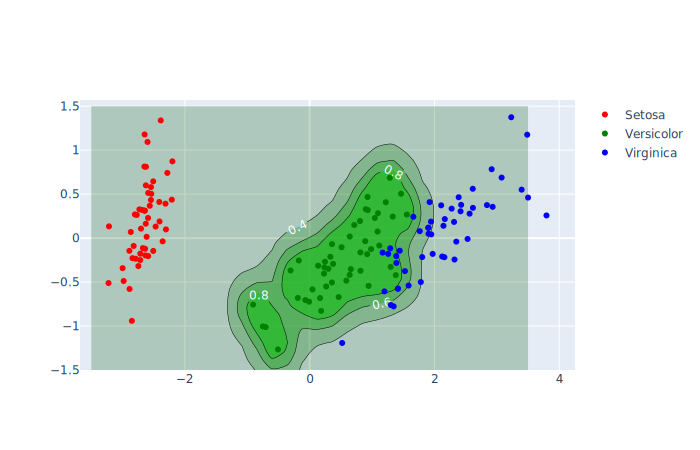

In [18]:
from mulearn.kernel import GaussianKernel

fi = FuzzyInductor(k=GaussianKernel(0.25))
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

The module contains also other kernel implementation: each implicitly defines the feature space. For instance, `LinearKernel` corresponds to having a feature space coinciding with the original pattern space. When used in conjunction with a linear fuzzifier, the contour plot of the inferred membership exhibits a linear decrease.

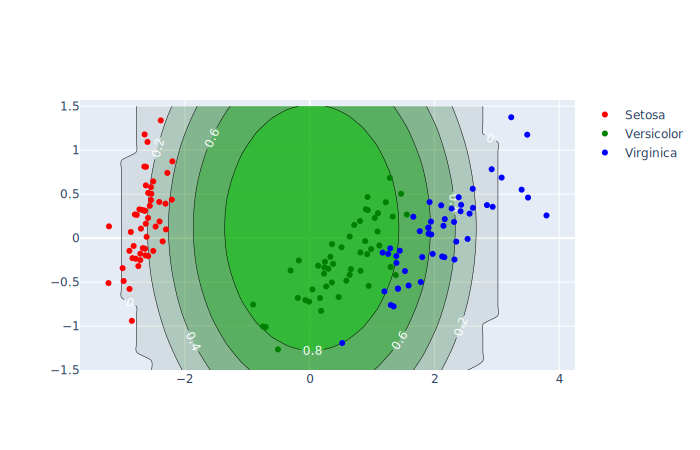

In [19]:
from mulearn.kernel import LinearKernel

fi = FuzzyInductor(k=LinearKernel(), fuzzifier=LinearFuzzifier())
fi.fit(iris_X_2d, iris_versicolor)
gr_membership_contour(fi.predict)

Note that the peculiar form of the outmost contour only apparently contradicts the linearity previously stated: this is due to the fact that this contour corresponds to a zone of the pattern space in which the membership rapidly decreases from 0.2 to 0, thus showing the 0.1 contour becomes difficult.

All kernels implemented in the `mulearn.kernel` are described here below.

### Linear kernel

Kernel corresponding to the dot product in the original space. This kernel is unique, thus it is instantiated invoking the constructor of the `LinearKernel` class without arguments.

In [20]:
from mulearn.kernel import LinearKernel
k = LinearKernel()

The kernel is computed invoking its `compute` method and specifying as arguments two tuples, lists, or arrays of the same length.

In [21]:
k.compute((1, 0, 2), (-1, 2, 5))

9.0

In [22]:
k.compute([1.2, -0.4, -2], [4, 1.2, .5])

3.3200000000000003

Different numeric iterables can intertwine as arguments.

In [23]:
k.compute((1.2, -0.4, -2), [4, 1.2, .5])

3.3200000000000003

Specification of iterables having unequal length causes a `ValueError` to be thrown.

## Polynomial kernel

Kernel corresponding to a dot product after mapping points on a higher-dimensional space through a polynomial (affine) transformation. A hyperplane in this space corresponds to polynomial surfaces in the original space.
Implemented via the `PolynomialKernel` class, instantiated in function of the degree of the corresponding transformation. The kernel is computed exactly as with `LinearKernel`.

In [24]:
from mulearn.kernel import PolynomialKernel

k = PolynomialKernel(2)
k.compute((1, 0, 2), (-1, 2, 5))

100.0

## Homogeneous polynomial kernel

Kernel corresponding to a dot product after mapping points on a higher-dimensional space through a polynomial (homogeneous) transformation. A hyperplane in this space corresponds to polynomial surfaces in the original space.  Implemented via the `HomogeneousPolynomialKernel` class, instantiated in function of the degree of the corresponding transformation. The kernel is computed exactly as with `LinearKernel`.

In [25]:
from mulearn.kernel import HomogeneousPolynomialKernel

k = HomogeneousPolynomialKernel(2)
k.compute((1, 0, 2), (-1, 2, 5))

81.0

## Gaussian kernel

Kernel corresponding to a dot product after mapping points on an infinite-dimensional space. A hyperplane in this space corresponds to the superposition of gaussian densities in the original space.  Implemented via the `GaussianKernel class`, instantiated in function of the standard deviation of the above mentioned densities. The kernel is computed exactly as with `LinearKernel`.

In [8]:
from mulearn.kernel import GaussianKernel

k = GaussianKernel(2)
k.compute((1, 0, 2), (-1, 2, 5))

0.11943296826671962

## Hyperbolic tangent kernel

Pseudo-kernel corresponding to a dot product based on hyperbolic tangent. Implemented via the `HyprebolicKernel` class, instantiated in function of the scale and offset parameters of the transformation given as argument to the hyperbolic tangent function. The kernel is computed exactly as with `LinearKernel`.

In [27]:
from mulearn.kernel import HyperbolicKernel

k = HyperbolicKernel(2)
k.compute((1, 0, 2), (-1, 2, 5))

0.9999999999999996

## Precomputed kernel

Custom kernel whose entries are precomputed and stored in a matrix. Implemented via the `PrecomputedKernel` class, instantiated in function of the matrix containing the kernel computations.

In [28]:
from mulearn.kernel import PrecomputedKernel
k = PrecomputedKernel(((9, 1, 4, 4),
                       (1, 1, 1, 1), 
                       (4, 1, 4, 1),
                       (4, 1, 1, 4)))

Specification of non-square matrices as arguments to the constructor causes a `ValueError` to be thrown.

The kernel is computed given the indices of the corresponding objects. Note that each index should be enclosed within an iterable in order to be compatible with sklearn.

In [29]:
k.compute([1], [1])

1.0

## Solvers

The `mulearn.optimization` module contains the implementations of solvers used in order to find the solution of a costrained optimization problem. The default solver relies on the gurobi library, which should be already installed and activated in the used system. This library is available for free for academic use. The class `GurobiSolver` implements the logic that solves the above mentioned problem using gurobi.

A second solver, based on TensorFlow, is available through the `TensorFlowSolver` class, which can be instantiated in order to provide a value for the `solver` parameter of the `FuzzyInductor` constructor. In this way, the solver based on TensorFlow can be used in all situations in which gurobi is not available, or when the processed dataset is too big to be efficiently handled by gurobi. Note, however, that the implementation of this solver is currently experimental, and might lead to suboptimal solutions.

In [25]:
%reload_ext autoreload
%autoreload 2

from tensorflow.keras.optimizers import Adam
from mulearn.optimization import TensorFlowSolver

try:
    solver=TensorFlowSolver(optimizer=Adam(learning_rate=0.1))

    fi = FuzzyInductor(solver=solver, k=GaussianKernel(0.25))
    fi.fit(iris_X_2d, iris_versicolor)
    gr_membership_contour(fi.predict)
except (ModuleNotFoundError, ValueError):
    print('Tensorflow not available')

i=0, dual=-8632.117, prim=-293.435, gap=-36.160110
i=10, dual=-12163.816, prim=9085.104, gap=-20663.523438
i=20, dual=-6967.269, prim=1021.619, gap=-150.532715
i=30, dual=-3221.032, prim=445.536, gap=919.796875
i=40, dual=-929.308, prim=438.175, gap=-260.587891
i=50, dual=-1681.285, prim=1065.885, gap=-2544.867188
i=60, dual=-1058.858, prim=-15.577, gap=799.515625
i=70, dual=-794.926, prim=99.331, gap=357.976562
i=80, dual=-678.652, prim=210.998, gap=-1.253464
i=90, dual=-865.100, prim=636.530, gap=-1313.429688
i=100, dual=-703.574, prim=589.960, gap=-1165.632812
i=110, dual=-605.386, prim=378.520, gap=-563.523438
i=120, dual=-606.433, prim=367.418, gap=-532.941406


In [19]:
gr_membership_contour(fi.predict)

ValueError: 
For some reason plotly.py was unable to communicate with the
local orca server process, even though the server process seems to be running.

Please review the process and connection information below:

orca status
-----------
    state: running
    executable: /home/malchiodi/share/anaconda3/envs/mulearn/bin/orca
    version: 1.3.1
    port: 37355
    pid: 105533
    command: ['/home/malchiodi/share/anaconda3/envs/mulearn/bin/orca', 'serve', '-p', '37355', '--plotly', '/home/malchiodi/share/anaconda3/envs/mulearn/lib/python3.7/site-packages/plotly/package_data/plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']




In [24]:
Q = [[1, 0], [0, 1]]
q = [0, 0]
A = [[1, 1]]
b = [1]
C = [[-1, -1], [1, 0], [0, 1], [-1, 0], [0, -1]]
d = [-1, 1, 1, 0, 0]

from tensorflow.keras.optimizers import Adam

solver=TensorFlowSolver(optimizer=Adam(learning_rate=0.1))

obj_val, lagr_val, x, lambda_, gap = \
           solver.solve_lagrange_relaxation(Q, q, A, b, C, d,
                                     max_gap=10**-3,
                                     verbose=True)

i=0, dual=0.487, prim=0.068, gap=0.582390
i=10, dual=1.947, prim=0.312, gap=0.176922
i=20, dual=2.469, prim=0.460, gap=0.037205
i=30, dual=2.970, prim=0.492, gap=0.007407
i=40, dual=3.470, prim=0.498, gap=0.001460


Both `GurobiSolver` and `TensorFlowSolver` have some parameters which can be set during class instantiation. These parameters are described in the package API.

## Model selection and assessment

As `FuzzyInductor` implements the standard interface of Scikit-learn, several of the tools provided by the latter can be used in conjunction with the induction of a fuzzy membership function. In particular, the use of `GridSearchCV` for model selection and model assessment is available out-of-the-box.

Relying on randomized techniquest such as `RandomizedSearchCV` for model selection requires the possibility of specifying a distribution for the involved hyperparameters which are defined through `GaussianKernel` or `ExponentialFuzzifier`. The module `mulearn.distributions` implements two additional classes related to these distributions, namely `GaussianKernelDistribution` and `ExponentialFuzzifierDistribution`.

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

from mulearn.distributions import GaussianKernelDistribution, \
                                  ExponentialFuzzifierDistribution

fi = FuzzyInductor()

params = {'c': uniform(loc=0, scale=10),
          'k': GaussianKernelDistribution(low=0.001, high=10),
          'fuzzifier': ExponentialFuzzifierDistribution()}

gs = RandomizedSearchCV(fi, params, verbose=0, n_jobs=-1,
                                pre_dispatch=10)
gs = gs.fit(iris_X_2d, iris_versicolor)

{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': Expon

{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}
{'c': 1, 'k': GaussianKernel(), 'fuzzifier': ExponentialFuzzifier(), 'solver': GurobiSolver(), 'random_state': None, 'chis_': None, 'gram_': None, 'fixed_term_': None, 'train_error_': None}


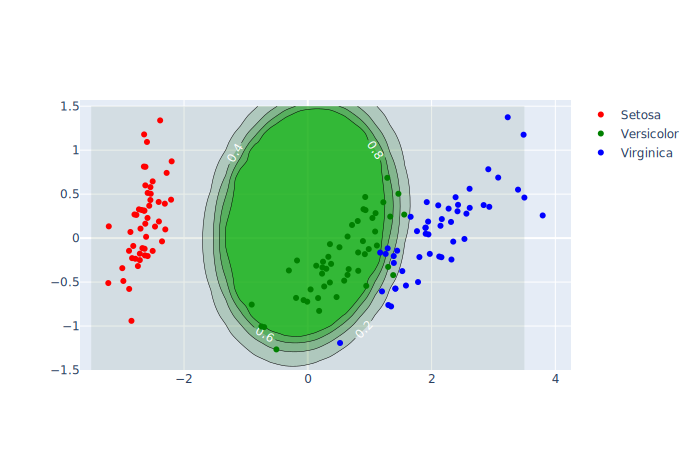

In [34]:
gr_membership_contour(gs.best_estimator_.predict)